# Starter Notebook

Install and import required libraries

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

In [17]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle
import transformers

## Load Tokenizer and Preprocess Data

In [5]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [6]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

## PreTraining

In [10]:
# Define the model checkpoint for the tokenizer and model backbone
base_model = "roberta-base"

# Load the AG News dataset from Hugging Face (train and test splits)
raw_datasets = load_dataset("ag_news")
train_dataset = raw_datasets["train"]
test_dataset = raw_datasets["test"]

# For validation during training, we'll split a portion of the training set
# (We do this since the official test labels might be hidden in a competition scenario)
split = train_dataset.train_test_split(test_size=0.1, seed=42)  # 10% for validation
train_dataset = split["train"]
val_dataset = split["test"]  # this is our validation set

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
# Initialize the tokenizer from the RoBERTa base model

tokenizer = RobertaTokenizer.from_pretrained(base_model)

# Define a preprocessing function to tokenize texts
def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

# Apply tokenization to all splits
train_dataset = train_dataset.map(preprocess, batched=True, remove_columns=["text"])
val_dataset   = val_dataset.map(preprocess, batched=True, remove_columns=["text"])
test_dataset  = test_dataset.map(preprocess, batched=True, remove_columns=["text"])

# Rename label column to "labels" (required by Transformers for our model)
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset   = val_dataset.rename_column("label", "labels")
test_dataset  = test_dataset.rename_column("label", "labels")

# Verify a sample
print(train_dataset[0])



Train set size: 108000
Validation set size: 12000
Test set size: 7600
{'labels': 0, 'input_ids': [0, 28324, 44170, 8, 39013, 11, 7090, 1083, 3171, 572, 43722, 1437, 163, 1723, 20606, 6, 798, 36, 1251, 43, 111, 20, 2429, 9, 55, 87, 21947, 1437, 408, 6, 1041, 8, 2948, 148, 5, 13629, 253, 7, 10, 1437, 4268, 12, 4509, 334, 19951, 314, 6254, 10, 284, 29929, 11, 5, 1437, 650, 1083, 1139, 9, 15191, 6847, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 

In [11]:
# Determine number of labels and label names from the dataset
num_labels = len(set(train_dataset["labels"]))  # or train_dataset.features["labels"].num_classes
if isinstance(train_dataset.features["labels"], ClassLabel):
    # If dataset has ClassLabel, we can get names
    label_names = train_dataset.features["labels"].names
else:
    # Otherwise, define names manually (AG News: 4 categories)
    label_names = ["World", "Sports", "Business", "Sci/Tech"]

print(f"Number of labels: {num_labels}")
print(f"Label names: {label_names}")

# Create id2label and label2id mappings for the model config
id2label = {i: name for i, name in enumerate(label_names)}
label2id = {name: i for i, name in enumerate(label_names)}


Number of labels: 4
Label names: ['World', 'Sports', 'Business', 'Sci/Tech']


In [12]:
# Initialize data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [13]:
# Load the pre-trained RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained(
    base_model, 
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Define LoRA configuration
lora_r = 2            # LoRA rank (can be adjusted, must keep total params < 1e6)
lora_alpha = 4        # LoRA scaling factor (often set proportional to r, e.g. 2*r)
lora_dropout = 0.05   # Dropout for LoRA layers
target_modules = ["query"]  # Target only the query projection of attention layers

peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias="none",
    target_modules=target_modules,
    task_type="SEQ_CLS"
)

# Wrap the base model with LoRA using the configuration
peft_model = get_peft_model(model, peft_config)

# Display the model to show LoRA layers added
peft_model.print_trainable_parameters()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 630,532 || all params: 125,279,240 || trainable%: 0.5033012652375605


In [14]:
# Function to count trainable parameters in the model
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

trainable_params = count_trainable_parameters(peft_model)
total_params = sum(p.numel() for p in peft_model.parameters())
print(f"Total parameters in model: {total_params:,}")
print(f"Total trainable parameters: {trainable_params:,}")

if trainable_params < 1_000_000:
    print("✅ Trainable parameter count is under 1 million.")
else:
    print("⚠️ Trainable parameter count exceeds 1 million!")


Total parameters in model: 125,279,240
Total trainable parameters: 630,532
✅ Trainable parameter count is under 1 million.


In [19]:
# Define a metrics computation function for evaluation (only accuracy for now)
def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(axis=-1)
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

# Set up TrainingArguments for the Trainer
training_args = TrainingArguments(
    output_dir="results",
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    logging_steps=100,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    log_level="error",
    report_to="none"
)

# Initialize the Trainer with our LoRA model, datasets, data collator, etc.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Training Setup

In [20]:
# Train the model (this may take some time depending on hardware)
train_result = trainer.train()

# The train_result contains training metrics like total steps and time
print("Training complete.")


Step,Training Loss
100,1.394700
200,1.396300
300,1.389400
400,1.395700
500,1.388100
600,1.384900
700,1.384400
800,1.384400
900,1.381100
1000,1.376800


Training complete.


In [22]:
# Extract training and evaluation metrics from the trainer's log history
import numpy as np
history = trainer.state.log_history

# Lists to store metrics for plotting
train_losses = []
val_accuracies = []
steps = []

for record in history:
    if 'loss' in record and 'step' in record:
        # Record training loss
        train_losses.append(record['loss'])
        steps.append(record['step'])
    if 'eval_accuracy' in record:
        # Record validation accuracy
        val_accuracies.append(record['eval_accuracy'])

# Convert to numpy for easier handling (optional)
train_losses = np.array(train_losses)
val_accuracies = np.array(val_accuracies)
steps = np.array(steps)

# Print out the final training loss and final validation accuracy
if train_losses.size > 0:
    print(f"Final training loss: {train_losses[-1]:.4f}")
if val_accuracies.size > 0:
    print(f"Validation accuracy at last evaluation: {val_accuracies[-1]:.4f}")

Final training loss: 0.3241


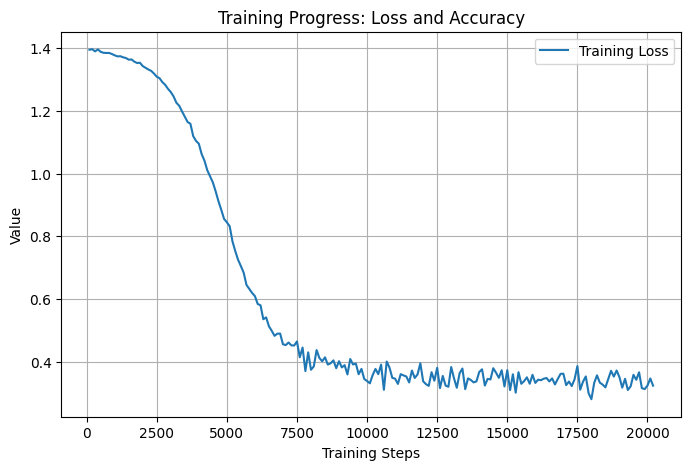

In [24]:
# Plot training loss and validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(steps, train_losses, label="Training Loss")
if val_accuracies.size > 0:
    plt.plot(steps, val_accuracies, label="Validation Accuracy")
plt.xlabel("Training Steps")
plt.ylabel("Value")
plt.title("Training Progress: Loss and Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## Testing

In [26]:
from sklearn.metrics import accuracy_score
# Evaluate the fine-tuned model on the test set
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test set accuracy: {test_metrics['eval_accuracy']:.4f}")
print(f"Total trainable parameters (final model): {count_trainable_parameters(peft_model):,}")



Test set accuracy: 0.8971
Total trainable parameters (final model): 630,532


In [27]:
# Example: Single prediction function
def predict_class(text):
    encoding = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}
    outputs = peft_model(**encoding)
    pred_label_id = outputs.logits.argmax(dim=-1).item()
    return id2label[pred_label_id]

# Predict on a couple of example texts
example_text1 = "Stocks rallied as the tech giant reported record profits for the quarter."
example_text2 = "The championship game went into overtime with an incredible last-minute goal."
print(f"Text: '{example_text1}'\nPredicted Category: {predict_class(example_text1)}")
print(f"\nText: '{example_text2}'\nPredicted Category: {predict_class(example_text2)}")


Text: 'Stocks rallied as the tech giant reported record profits for the quarter.'
Predicted Category: Business

Text: 'The championship game went into overtime with an incredible last-minute goal.'
Predicted Category: Sports


## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [ ]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")

### Run Inference on eval_dataset

In [32]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
        batch_size (int): Batch size for inference.
        data_collator: Collator for padding and batching.

    Returns:
        If labelled is True: returns (metrics, predictions)
        If labelled is False: returns predictions only.
    """
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        preds = outputs.logits.argmax(dim=-1)
        all_predictions.append(preds.cpu())

        if labelled:
            metric.add_batch(
                predictions=preds.cpu().numpy(),
                references=batch["labels"].cpu().numpy()
            )

    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        final_metric = metric.compute()
        print("Evaluation Accuracy:", final_metric["accuracy"])
        return final_metric, all_predictions
    else:
        return all_predictions


In [33]:
# Run evaluation
eval_metric, predictions = evaluate_model(peft_model, val_dataset, labelled=True, batch_size=8, data_collator=data_collator)

# Show result
print(f"Final Validation Accuracy: {eval_metric['accuracy']:.4f}")


Evaluating: 100%|██████████| 1500/1500 [00:41<00:00, 36.39it/s]

Evaluation Accuracy: 0.89475
Final Validation Accuracy: 0.8948


### Run Inference on unlabelled dataset

In [31]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

FileNotFoundError: [Errno 2] No such file or directory: 'test_unlabelled.pkl'

In [ ]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")